In [25]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.plotter as pltutils

reload(polc)
reload(expt)
reload(pltutils);

## Simulation Parameters

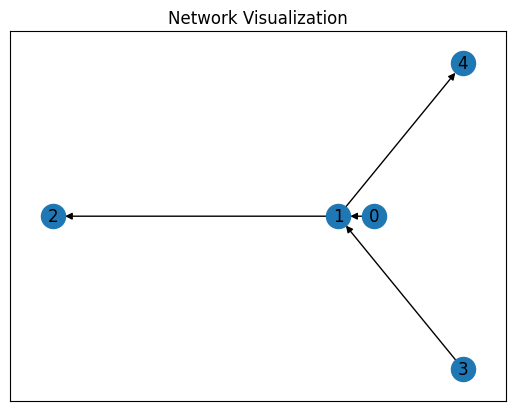

In [26]:
# simulation lengths 
# Use T_horizon = 10000 and N_runs = 500 to recreate the plots from the paper
T_horizon = None # time horizon 
T_horizon_list = np.linspace(1,1000,10, dtype=int)
N_runs = 1000 # number of simulations

# noise and arrival rates
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
noise_distribution = random_uniform # np.random.standard_normal
noise_variance = 0.05 # sigma^2

# algorithm parameters
beta  = 4.5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
edges_list = [[0,1], [1,2], [3,1], [1,4]]
N_nodes    = 5
N_edges    = len(edges_list)
node_edge_adjacency = expt.prepare_adjacency(edges_list, N_nodes)

# Commodities. Note: this assumes each commodity has a single source, maybe I can improve this in future
arrival_rate_list = [3, 1] # arrival rates for each commodity
source_list       = [0, 3] # source node for each commodity, should follow the same order as arrival rates
destination_list  = [2, 4] # destination node for each commodity, should follow the same order as arrival rates
N_commodities     = len(destination_list)

# edge properties
edge_capacities = np.array([4,6,2,3]) # max-flow = [4,2]
true_edge_costs = np.array([2,5,1,1])/10

# pack parameters
simulation_params = expt.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_list, destination_list, 
                 noise_variance, noise_distribution,
                 arrival_rate_list, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
pltutils.visualize_network(edges_list, N_nodes)

## Static Policy

In [27]:
true_edge_costs.shape

(4,)

In [28]:
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, simulation_params)
stat_cost_at_tt = np.sum(stat_edge_rates.reshape([N_commodities, N_edges])@true_edge_costs)
stat_costs = T_horizon_list*stat_cost_at_tt

# get solution to static optimization problem
# stat_edge_rates = polc.get_static_policy(node_edge_adjacency, simulation_params)
# total_stat_cost_per_time = stat_edge_rates@true_edge_costs
# stat_costs = T_horizon_list*total_stat_cost_per_time

## DPOP Policy

In [29]:
# intialization
tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)

# iterate over given T values
for ii in trange(T_horizon_list.shape[0]):
    # ii = T_horizon_list.shape[0] - jj - 1

    # change policy parameters for this value of T
    simulation_params = expt.set_simulation_params(simulation_params, T_horizon_list[ii])

    # run experiment for this value of T
    queueing_network = expt.run_experiment(simulation_params, custom_seed = 13)
    
    # save cost and backlog values
    tran_cost_till_T_dpop[ii], backlog_cost_at_T_dpop[ii] = expt.calculate_total_costs(queueing_network)

# calculate total cost
dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


## Results Summary

Fit co-effs [1 sqrt(T)log(T)] = [70.703  0.496]
Arrival rate = [3, 1], noise variance = 0.05
True costs = [0.2 0.5 0.1 0.1]
Mean observed costs = [0.199 0.506 0.09  0.102]


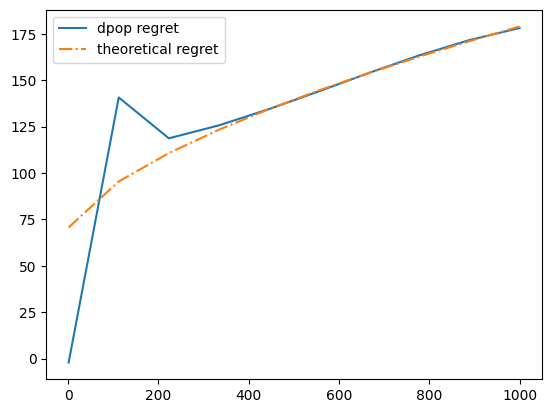

In [30]:
# save results
save_directory = './results'
save_result = {'T_horizon_list': T_horizon_list, 
                'dpop_costs': dpop_costs, 
                'stat_costs':stat_costs, 
                'edge_cost_means': queueing_network.edge_cost_means[0,:], 
                'true_edge_costs': true_edge_costs}
# save_file = 'regret-lambda-' + str(arrival_rate).replace('.','_') + '-var-' + str(noise_variance).replace('.','_') + '.pkl'
# if(save_directory is not None): 
#     with open(save_directory + '/' + save_file, 'wb') as f: pkl.dump(save_result, f)

# get theoretical fit
dpop_regret = dpop_costs - stat_costs
theoretical_dpop_regret = pltutils.fit_regret_curve(T_horizon_list, dpop_regret)

# print summary
print('Arrival rate = ' + str(arrival_rate_list) + ', noise variance = ' + str(noise_variance))
print('True costs = ' + str(true_edge_costs))
print('Mean observed costs = ' + np.array2string(queueing_network.edge_cost_means[0,:], precision=3, suppress_small=True))

# plot regret
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()